In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/art-images-drawings-painting-sculpture-engraving"))

# Any results you write to the current directory are saved as output.

['art_dataset_cleaned']


In [2]:
from fastai import *
from fastai.vision import *

In [3]:
#Take PATH to be the parent folder of training and valid set.
PATH = "../input/art-images-drawings-painting-sculpture-engraving/art_dataset_cleaned/art_dataset"

In [4]:
torch.cuda.is_available()

True

In [5]:
#do_flip=False because we do not want our paintings to be trained flipped or in any other rotation.
tfms = get_transforms(do_flip=False)

#size = the maximum size of our images, use 224 for most cases as told by Jeremy. 
#num_workers = 0, the number of CPUs to use. 0 due to lower hardware in Kaggle. 
#If training and valid set are already available, direct the function to them via the method below via arguments train and valid. 
data = ImageDataBunch.from_folder(PATH, train="training_set", valid="validation_set", ds_tfms=tfms, size=200, num_workers=0)

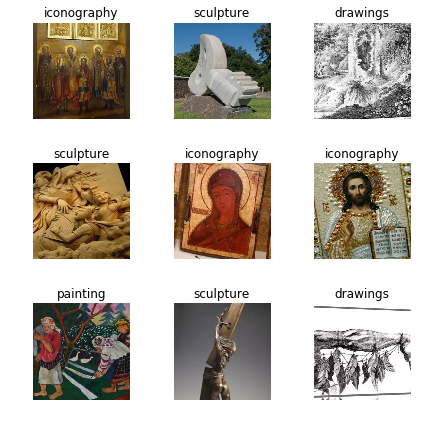

In [6]:
data.show_batch(rows=3, figsize=(6,6))

In [7]:
data.classes

['drawings', 'engraving', 'iconography', 'painting', 'sculpture']

In [8]:
#BEFORE THIS STEP, Click on Add Data and Search for Resnet34 from Kaggle. Because Kaggle serves read-only dirs, we cannot download pre-trained weights for Resnet. Now we have to make a dir 
#for copying those weights and hence we are making ~/.torch/models folder. 
cache_dir = os.path.expanduser(os.path.join('~','.torch'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir) #first make ~/.torch if not already available.

In [9]:
models_dir = os.path.join(cache_dir,'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir) #then make ~/.torch/models, if not already available. 

In [10]:
#Copied resnet34.pth, which are pretrained weights on Resnet34 to our folder into resnet<version>-<sha-hash>.pth
!cp ../input/resnet34/resnet34.pth ~/.torch/models/resnet34-333f7ec4.pth 

In [11]:
#MODEL_PATH is declared this way and glued to model_dir attr of cnn_learner.
MODEL_PATH = '/tmp/models'
learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir=MODEL_PATH)

In [12]:
#Fitting and checking for the first time. 
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.489632,0.265858,0.901869,02:02
1,0.301034,0.202761,0.925234,01:56
2,0.233835,0.189954,0.929907,01:57
3,0.199139,0.181202,0.934579,01:55


In [13]:
#Saving the model with ACCURACY = 93.4%
learn.save('stage-1')

In [14]:
#Initiating refit and checking LR
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


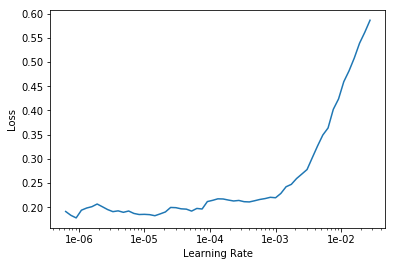

In [15]:
learn.recorder.plot()

In [16]:
#The lowest loss is at 1e-06 and loss increases from after 1e-04. Refitting by modulating LR
learn.fit_one_cycle(2,max_lr=slice(1e-05,1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.186892,0.163934,0.940421,02:01
1,0.139290,0.150968,0.940421,02:01


In [17]:
#Saving the model with accuracy 93.6%
learn.save('stage-2')

In [18]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


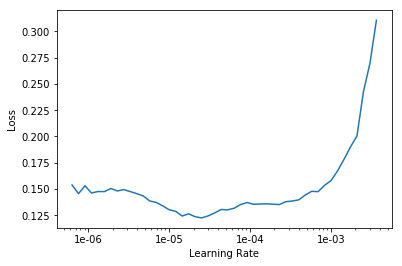

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2,max_lr=slice(1e-06,1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.114904,0.150118,0.947430,02:00
1,0.110616,0.144483,0.947430,02:00


In [21]:
#Saving model with acc 94.7%
learn.save('stage-3')

In [27]:
#Uploaded a separate dataset for testing each of the above classes.
PRED_PATH = "../input/for-testing-art-images-cnn"
img_icono = open_image(f'{PRED_PATH}/icono.jpg')
img_drawing = open_image(f'{PRED_PATH}/drawing.jpg')
img_engraving = open_image(f'{PRED_PATH}/engraving.png')
img_painting = open_image(f'{PRED_PATH}/painting.jpg')
img_sculpt = open_image(f'{PRED_PATH}/sculpture.jpg')

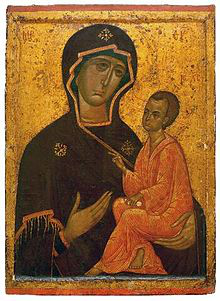

In [30]:
img_icono

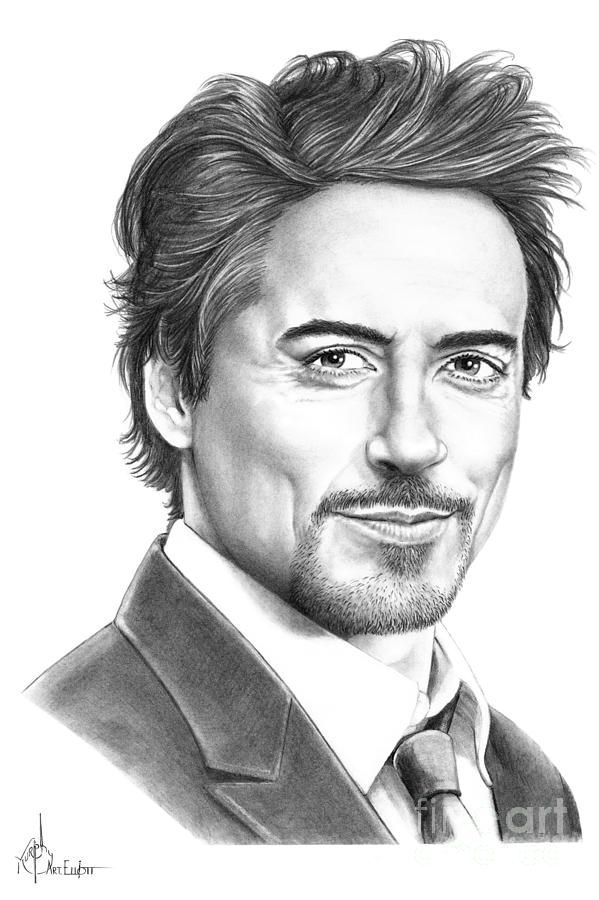

In [31]:
img_drawing

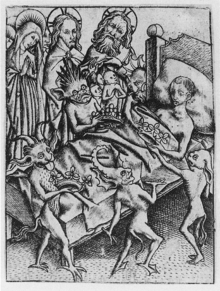

In [32]:
img_engraving

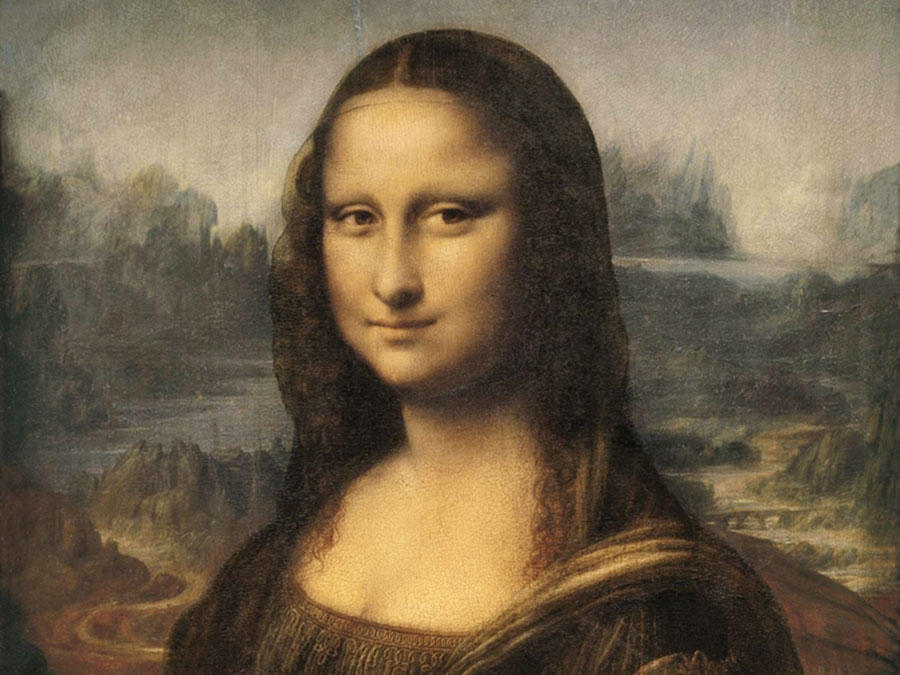

In [33]:
img_painting

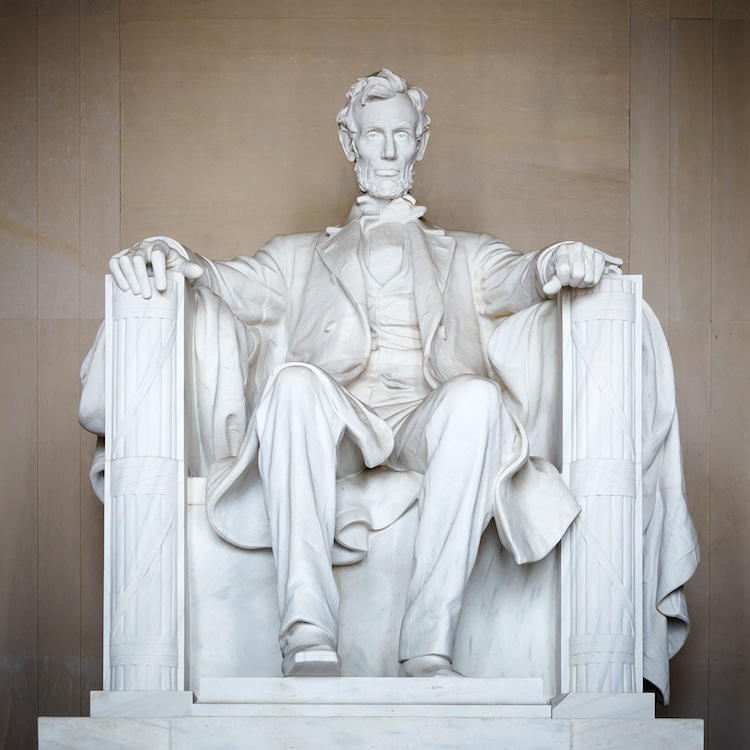

In [34]:
img_sculpt

In [36]:
learn.load('stage-3')
pred_class = learn.predict(img_icono)
pred_class
#The iconography is correctly identified in its specified category.

(Category iconography,
 tensor(2),
 tensor([6.4216e-07, 2.8668e-06, 9.9999e-01, 1.5303e-06, 2.8591e-08]))

In [37]:
pred_class = learn.predict(img_drawing)
pred_class
#The sketch of Robert Downey Jr. is correctly identified as a drawing. 

(Category drawings,
 tensor(0),
 tensor([9.5027e-01, 3.9309e-02, 3.6643e-04, 3.6381e-03, 6.4128e-03]))

In [39]:
pred_class = learn.predict(img_painting)
pred_class
#The MonaLisa painting has been incorrectly identified as a drawing too. 

(Category drawings,
 tensor(0),
 tensor([0.5862, 0.1606, 0.0067, 0.2367, 0.0097]))

In [40]:
pred_class = learn.predict(img_sculpt)
pred_class
#The Abraham Lincoln statue is correctly predicted as a sculpture.

(Category sculpture,
 tensor(4),
 tensor([1.5215e-04, 1.6432e-04, 5.0656e-04, 2.4123e-04, 9.9894e-01]))

In [41]:
pred_class = learn.predict(img_engraving)
pred_class
#The engraving is correctly identified in its specified category.

(Category engraving,
 tensor(1),
 tensor([4.5636e-02, 9.5435e-01, 1.0390e-05, 2.7635e-06, 4.8394e-06]))